In [13]:
import kagglehub
Sptify_23_dataset_path = kagglehub.dataset_download('maharshipandya/-spotify-tracks-dataset')

print('Data source import complete.')

Data source import complete.


In [14]:
pip install annoy

Note: you may need to restart the kernel to use updated packages.


In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics.pairwise import cosine_similarity
from annoy import AnnoyIndex
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import silhouette_score, silhouette_samples
import random

# DTSA-5510: Unsupervised Learning Final Project
## Spotify song recommender system

For my final project, I wanted to expand on something that we have learned about in class, which was recommendation systems. I wanted to practice cleaning larger data and transforming the data for a model to learn from and reccomend like songs. For this project I will be using a top streamed spotify songs[ dataset ](https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset?select=dataset.csv)procured from Kaggle.

Here is my general plan for this project:



1.   Import and Clean the Data
2.   Perform an EDA. I'll do this with untransformed data for comprehensibility. I will also normalize numerical features for distance-based similarity and encode categorical features.
3.   I will then build a content-based recommender using K-Means and cosine similarity to find songs with similar audio features. K-Means will improve efficiency by reducing search space, while Cosine similarity ensures acoustic similarity within clusters.



In [19]:
music_df = pd.read_csv('/kaggle/input/-spotify-tracks-dataset/dataset.csv')
music_df.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [20]:
music_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalness  114000 non-null  float64
 16  liveness          11

Here I separated the audio features from the data frame to facilitate easier calls for future methods.

In [18]:
audio_feat = ['danceability',	'energy',	'key',	'loudness',	'mode',	'speechiness',	'acousticness',	'instrumentalness',	'liveness',	'valence',	'tempo',	'time_signature']

In [40]:

music_df[audio_feat].isnull().sum()



duration_ms         0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
dtype: int64

In [41]:
music_df[audio_feat].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   duration_ms       114000 non-null  float64
 1   danceability      114000 non-null  float64
 2   energy            114000 non-null  float64
 3   key               114000 non-null  float64
 4   loudness          114000 non-null  float64
 5   mode              114000 non-null  float64
 6   speechiness       114000 non-null  float64
 7   acousticness      114000 non-null  float64
 8   instrumentalness  114000 non-null  float64
 9   liveness          114000 non-null  float64
 10  valence           114000 non-null  float64
 11  tempo             114000 non-null  float64
 12  time_signature    114000 non-null  float64
dtypes: float64(13)
memory usage: 11.3 MB


In [75]:
music_df = music_df.rename(columns = {'track_name': 'name'})

## Visualize Feature Distributions
With the feature exploration from heatmap and pairwise plots, we can see that the most correlated and relevant feature combinations are valence with danceability and energy with loudness.

In [24]:
corr_matrix = feats.corr()
corr_matrix.style.background_gradient(cmap = 'coolwarm')

,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
duration_ms,1.000000,-0.073426,0.058523,0.008114,-0.003470,-0.035556,-0.062600,-0.103788,0.124371,0.010321,-0.154479,0.024346,0.018225
danceability,-0.073426,1.000000,0.134325,0.036469,0.259077,-0.069219,0.108626,-0.171533,-0.185606,-0.131617,0.477341,-0.050450,0.207218
energy,0.058523,0.134325,1.000000,0.048006,0.761690,-0.078362,0.142509,-0.733906,-0.181879,0.184796,0.258934,0.247851,0.187126
key,0.008114,0.036469,0.048006,1.000000,0.038590,-0.135916,0.020418,-0.040937,-0.006823,-0.001600,0.034103,0.010917,0.015065
loudness,-0.003470,0.259077,0.761690,0.038590,1.000000,-0.041764,0.060826,-0.589803,-0.433477,0.076899,0.279848,0.212446,0.191992
mode,-0.035556,-0.069219,-0.078362,-0.135916,-0.041764,1.000000,-0.046532,0.095553,-0.049955,0.014012,0.021953,0.000566,-0.024092
speechiness,-0.062600,0.108626,0.142509,0.020418,0.060826,-0.046532,1.000000,-0.002186,-0.089616,0.205219,0.036635,0.017273,-0.000011
acousticness,-0.103788,-0.171533,-0.733906,-0.040937,-0.589803,0.095553,-0.002186,1.000000,0.104027,-0.020700,-0.107070,-0.208224,-0.176138
instrumentalness,0.124371,-0.185606,-0.181879,-0.006823,-0.433477,-0.049955,-0.089616,0.104027,1.000000,-0.079893,-0.324312,-0.050330,-0.082580
liveness,0.010321,-0.131617,0.184796,-0.001600,0.076899,0.014012,0.205219,-0.020700,-0.079893,1.000000,0.019086,0.000600,-0.023651


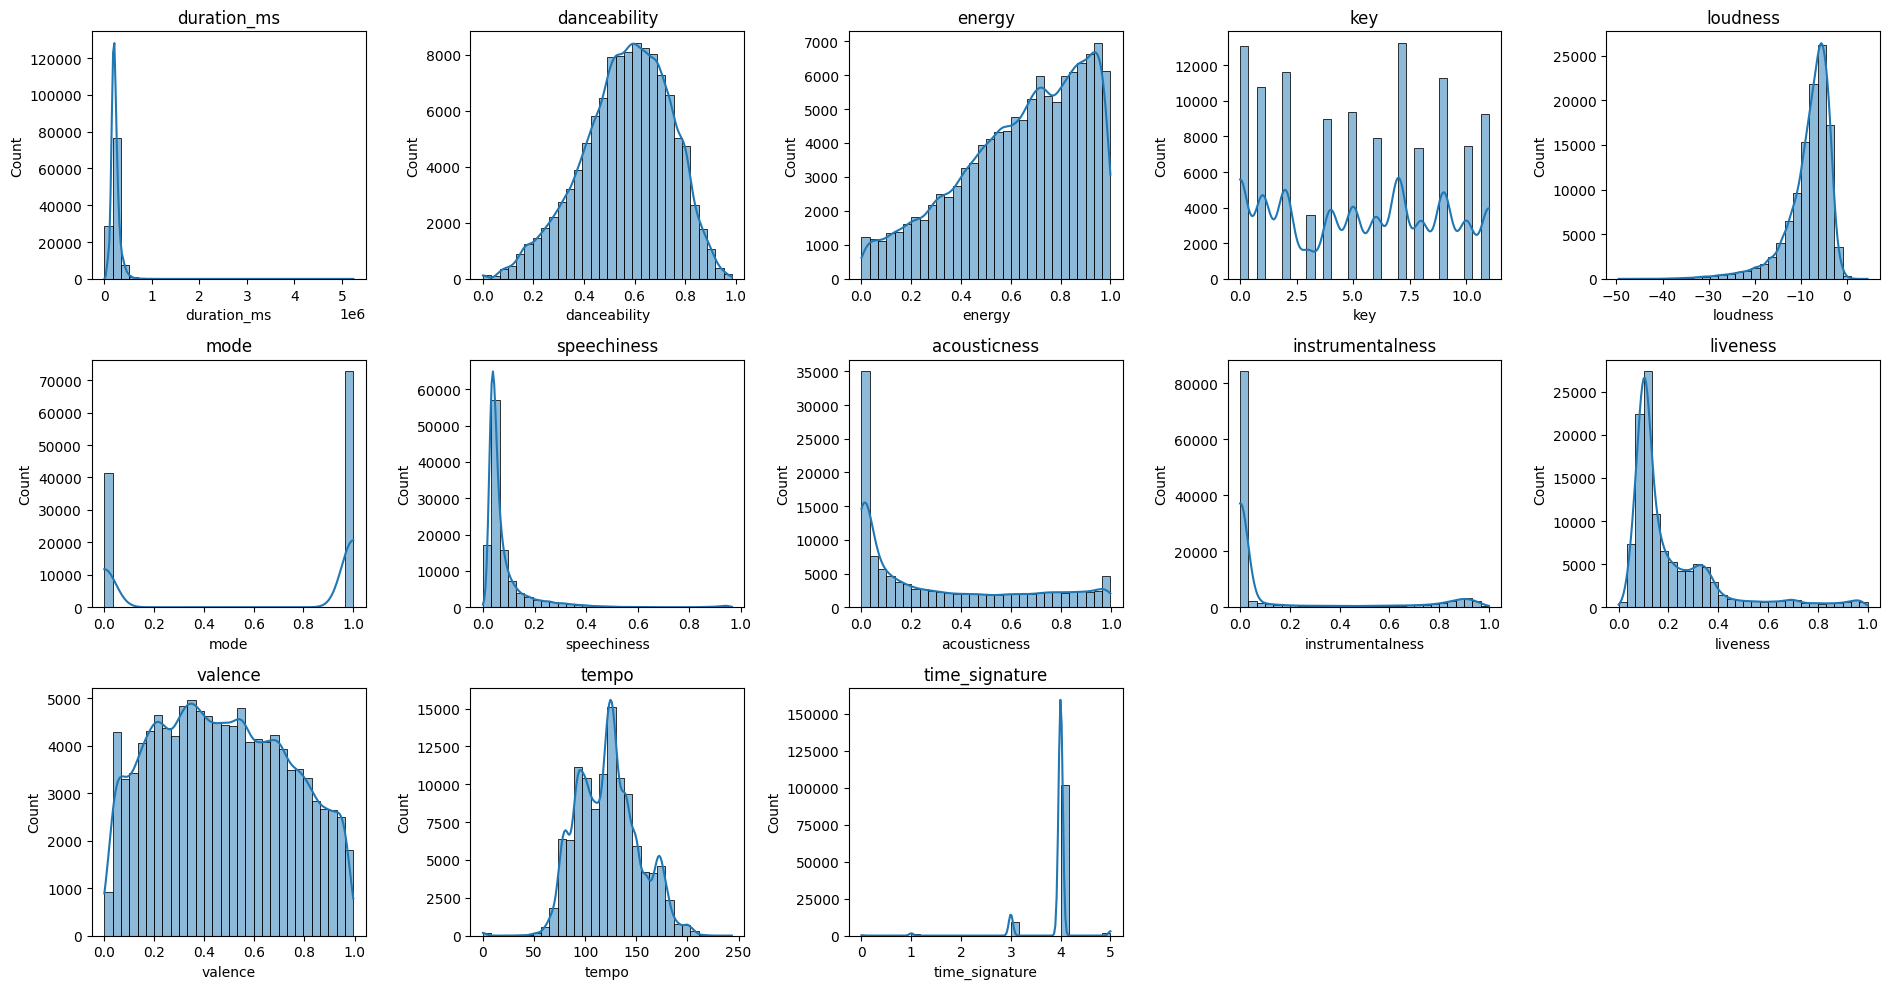

In [29]:
plt.figure(figsize=(19, 10))
for i, feature in enumerate(audio_feat):
    plt.subplot(3, 5, i+1)
    sns.histplot(music_df[feature], kde=True, bins=30)
    plt.title(feature)
plt.tight_layout()
plt.show()

## PCA
Here we scaled the numerical data then plotted the explained variance and performed pca to reduce the data to a manageable size. From the plot we can see that the first 2 components likely capture around 70 percent of the total variance and between 4 to 6 components yields 85-95 percent of the variance. We can also see that after 6, the curve flattens greatly leading to minimal gains, hence our ideal number of components would be 6.

In [32]:
scaler = MinMaxScaler()
music_df[audio_feat] = scaler.fit_transform(music_df[audio_feat])

# Reduce dimensionality with PCA
pca = PCA(n_components=0.95)  # Retains 95% variance
reduced_features = pca.fit_transform(music_df[audio_feat])
music_df[['pca1', 'pca2']] = reduced_features[:, :2]

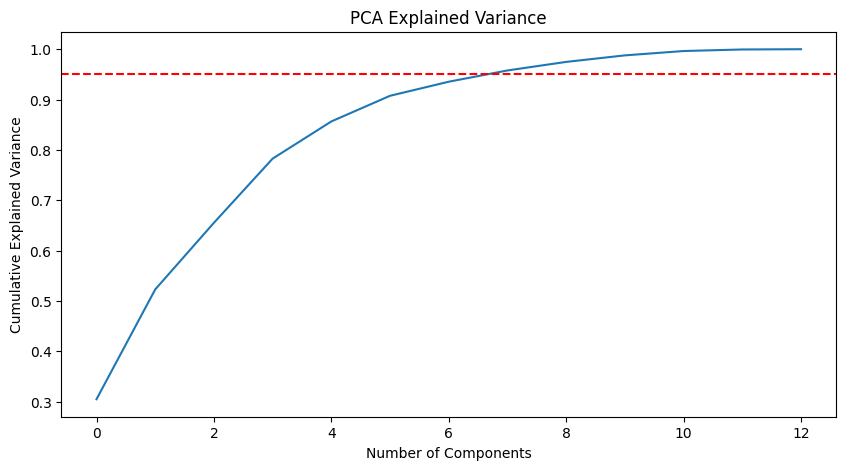

In [33]:
pca_full = PCA().fit(music_df[audio_feat])

plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--')
plt.title("PCA Explained Variance")
plt.show()

In [34]:
pca = PCA().fit(music_df[audio_feat])
print(np.cumsum(pca.explained_variance_ratio_))

[0.3049073  0.52294045 0.65531787 0.7827481  0.85657986 0.90752176
 0.93547557 0.95784111 0.97483925 0.9877886  0.99643614 0.99949357
 1.        ]


## KMeans and Cosine Similarity
For this project I will be utilizing K-Means and a precomputed cosine-similarity to save processing space but also to optimize the reccomender system. From our elbow plot we can see that the optimal number of clusters is 6, where we recieve increasingly diminshing returns. 

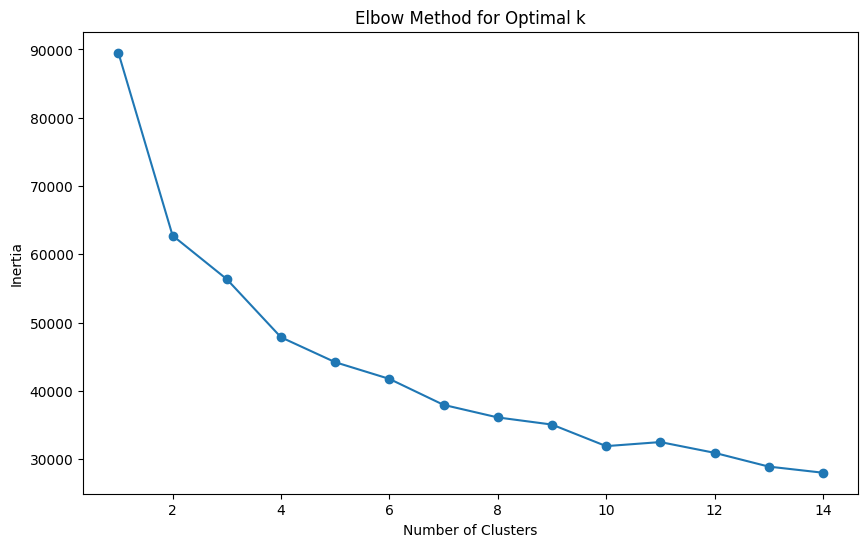

In [35]:
inertias = []
for k in range(1, 15):
    kmeans = MiniBatchKMeans(n_clusters=k, batch_size=1000, random_state=42)
    kmeans.fit(music_df[audio_feat])
    inertias.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 15), inertias, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title("Elbow Method for Optimal k")
plt.show()

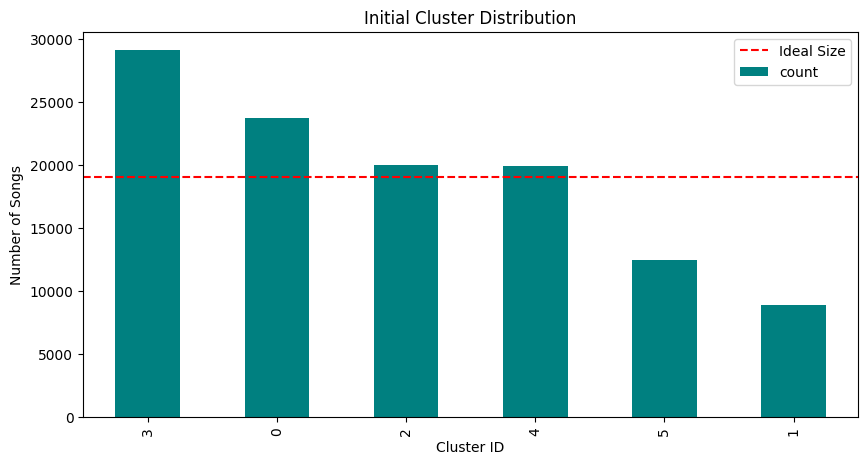

In [60]:
# Fit with optimal k
optimal_k = 6
kmeans = MiniBatchKMeans(n_clusters=optimal_k, batch_size=1000, random_state=42)
music_df['cluster'] = kmeans.fit_predict(music_df[audio_feat])

# Plot clusters
plt.figure(figsize=(10, 5))
cluster_counts = music_df['cluster'].value_counts()
cluster_counts.plot.bar(color='teal')
plt.axhline(y=len(music_df)/optimal_k, color='r', linestyle='--', label='Ideal Size')
plt.title("Initial Cluster Distribution")
plt.xlabel("Cluster ID")
plt.ylabel("Number of Songs")
plt.legend()
plt.show()

# Cluster rebalancing

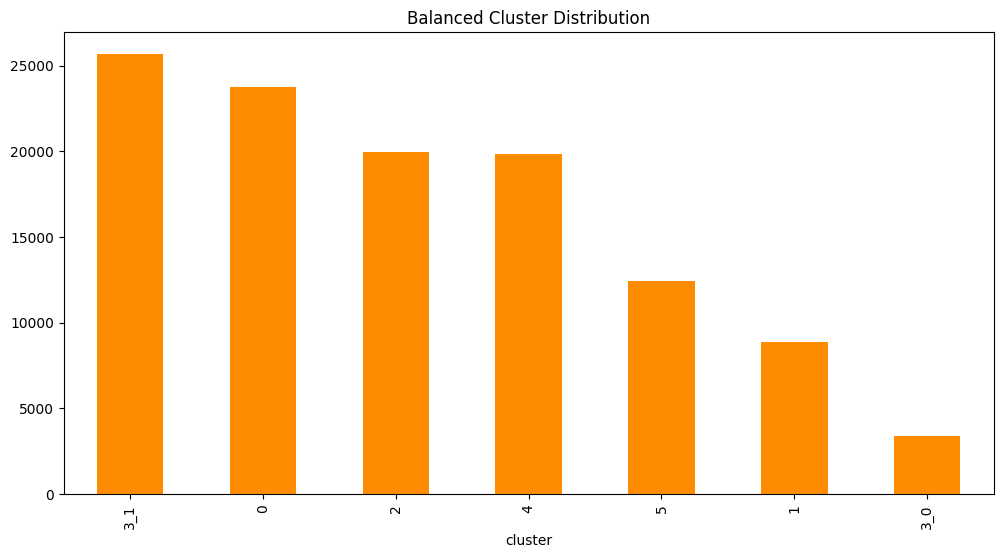

In [63]:
large_clusters = cluster_counts[cluster_counts > 1.5*(len(music_df)/optimal_k)].index
for c in large_clusters:
    cluster_data = music_df[music_df['cluster'] == c]
    sub_k = max(2, int(len(cluster_data)/(len(music_df)/optimal_k)))
    sub_kmeans = KMeans(n_clusters=sub_k, random_state=42)
    sub_labels = sub_kmeans.fit_predict(cluster_data[audio_feat])
    music_df.loc[cluster_data.index, 'cluster'] = [f"{c}_{sub}" for sub in sub_labels]

# Visualize balanced clusters
plt.figure(figsize=(12, 6))
music_df['cluster'].value_counts().plot.bar(color='darkorange')
plt.title("Balanced Cluster Distribution")
plt.show()

# Silhouette Score and Cosine Similarity implementation

Here, we utilize the silhouette score to measure how similar a song is to its own cluster vs. other clusters. We have a silhouette score of .205, which on the scale between -1 to 1 is not the best but it is reasonable.

In [66]:
# Create numeric cluster IDs for silhouette calculation
cluster_id_map = {cluster: idx for idx, cluster in enumerate(music_df['cluster'].unique())}
music_df['cluster_numeric'] = music_df['cluster'].map(cluster_id_map)

# Verify conversion
print("Cluster label mapping:")
print(cluster_id_map)

Cluster label mapping:
{2: 0, 4: 1, 0: 2, '3_1': 3, 1: 4, 5: 5, '3_0': 6}


In [68]:
silhouette_avg = silhouette_score(reduced_features, music_df['cluster_numeric'])
print(f"\nOverall Silhouette Score: {silhouette_avg:.3f}")

# Per-sample scores for visualization
sample_silhouette_values = silhouette_samples(reduced_features, music_df['cluster_numeric'])


Overall Silhouette Score: 0.202


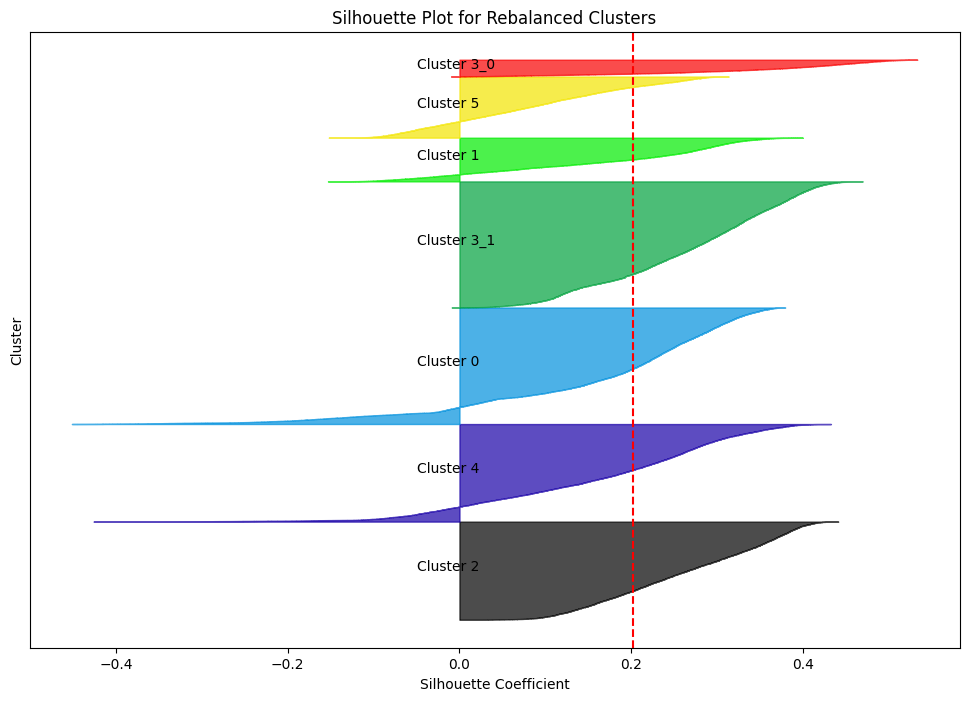

In [69]:
plt.figure(figsize=(12, 8))
y_lower = 10

for i in range(len(cluster_id_map)):
    # Aggregate silhouette scores for cluster i
    ith_cluster_silhouette = sample_silhouette_values[music_df['cluster_numeric'] == i]
    ith_cluster_silhouette.sort()
    
    size_cluster_i = ith_cluster_silhouette.shape[0]
    y_upper = y_lower + size_cluster_i
    
    # Color mapping
    color = plt.cm.nipy_spectral(float(i) / len(cluster_id_map))
    plt.fill_betweenx(
        np.arange(y_lower, y_upper),
        0, ith_cluster_silhouette,
        facecolor=color, edgecolor=color, alpha=0.7
    )
    
    # Label clusters
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, 
             f"Cluster {list(cluster_id_map.keys())[i]}")
    y_lower = y_upper + 10  # Add gap between clusters

plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.title("Silhouette Plot for Rebalanced Clusters")
plt.xlabel("Silhouette Coefficient")
plt.ylabel("Cluster")
plt.yticks([])  # Hide y-axis labels
plt.show()


Here, because the data is simply to large to process individually and get the cosine similarity between each individual point, we utilize the annoy index to approximate nearest neighbors. Following we optimize the distance metric and get the annoy hit rate to evaluate the accuracy of the cosine similarity between recommendations. From below we can see that we have an intracluster similarity of .994. This value is very good and shows us that the reccomendations are accoustically similar. Although this may be inflated from the limited data, for our datset of around 10 thousand songs this is quite good. 

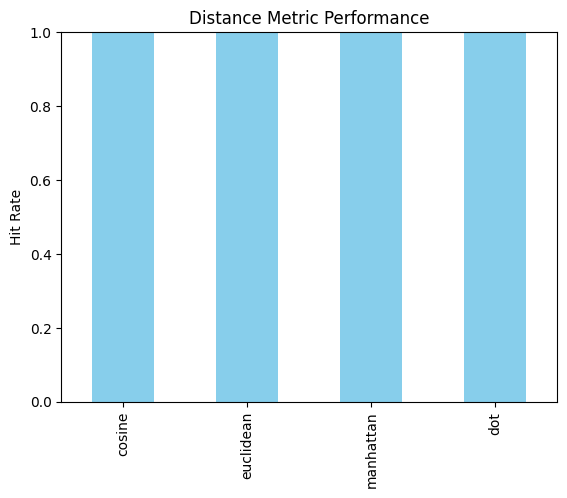

Selected metric: cosine


In [70]:
distance_metrics = {
    'cosine': 'angular',
    'euclidean': 'euclidean', 
    'manhattan': 'manhattan',
    'dot': 'dot'
}

metric_performance = {}
for metric_name, annoy_metric in distance_metrics.items():
    indices = {}
    for cluster_id in music_df['cluster'].unique():
        cluster_data = music_df[music_df['cluster'] == cluster_id]
        features = cluster_data[['pca1', 'pca2']].values
        index = AnnoyIndex(features.shape[1], annoy_metric)
        for i, vec in enumerate(features):
            index.add_item(i, vec)
        index.build(10)
        indices[cluster_id] = index
    
    # Evaluation function
    def evaluate():
        hit_rates = []
        for _ in range(100):
            test_idx = random.choice(music_df.index)
            cluster_id = music_df.loc[test_idx, 'cluster']
            pos = music_df[music_df['cluster']==cluster_id].index.get_loc(test_idx)
            neighbors = indices[cluster_id].get_nns_by_item(pos, 5)
            hit_rates.append(len(neighbors)/5)
        return np.mean(hit_rates)
    
    metric_performance[metric_name] = evaluate()

# Results visualization
pd.Series(metric_performance).plot.bar(color='skyblue')
plt.title("Distance Metric Performance")
plt.ylabel("Hit Rate")
plt.ylim(0, 1)
plt.show()

best_metric = max(metric_performance, key=metric_performance.get)
print(f"Selected metric: {best_metric}")

In [82]:
final_indices = {}
for cluster_id in music_df['cluster'].unique():
    cluster_data = music_df[music_df['cluster'] == cluster_id]
    features = cluster_data[['pca1', 'pca2']].values
    index = AnnoyIndex(features.shape[1], distance_metrics[best_metric])
    for i, vec in enumerate(features):
        index.add_item(i, vec)
    index.build(50)  # High number of trees for accuracy
    final_indices[cluster_id] = index

In [87]:
def optimized_recommend(song_name, artist_name=None, n=5, verbose=True):
    # Find input song
    if artist_name:
        input_song = music_df[(music_df['name'] == song_name) & 
                       (music_df['artists'].str.contains(artist_name))].iloc[0]
    else:
        input_song = music_df[music_df['name'] == song_name].iloc[0]
    
    cluster_id = input_song['cluster']
    cluster_data = music_df[music_df['cluster'] == cluster_id].reset_index(drop=True)
    
    # Get position in cluster (must be integer)
    pos_in_cluster = cluster_data.index[cluster_data['name'] == song_name][0]
    
    # Step 1: Approximate search
    annoy_index = final_indices[cluster_id]
    neighbor_indices = annoy_index.get_nns_by_item(pos_in_cluster, n*3)  # Get extra candidates
    
    # Step 2: Exact re-ranking
    candidates = cluster_data.iloc[neighbor_indices]
    input_vec = input_song[audio_feat].values.reshape(1, -1)
    candidate_vecs = candidates[audio_feat].values
    exact_scores = cosine_similarity(input_vec, candidate_vecs)[0]
    
    # Get top-N after re-ranking
    top_indices = np.argsort(exact_scores)[-n:][::-1]
    recommendations = candidates.iloc[top_indices]
    
    if verbose:
        intra_sim = np.mean(cosine_similarity(recommendations[audio_feat]))
        print(f"\nRecommendation Quality:")
        print(f"- Intra-cluster similarity: {intra_sim:.3f}")
        print(f"- Cluster diversity: {recommendations['cluster'].nunique()}/{n} clusters")
    
    return recommendations[['name', 'artists', 'cluster']]

In [88]:
recs = optimized_recommend("Blinding Lights", "The Weeknd")
print("\nRecommended Songs:")
recs


Recommendation Quality:
- Intra-cluster similarity: 0.994
- Cluster diversity: 1/5 clusters

Recommended Songs:


,name,artists,cluster
522,Ciencia De La Lluvia,Enjambre,0
10202,We’ll Be Back,Megadeth,0
2035,Slayed,Overseer,0
13589,未完,Mr.Children,0
13414,未完,Mr.Children,0


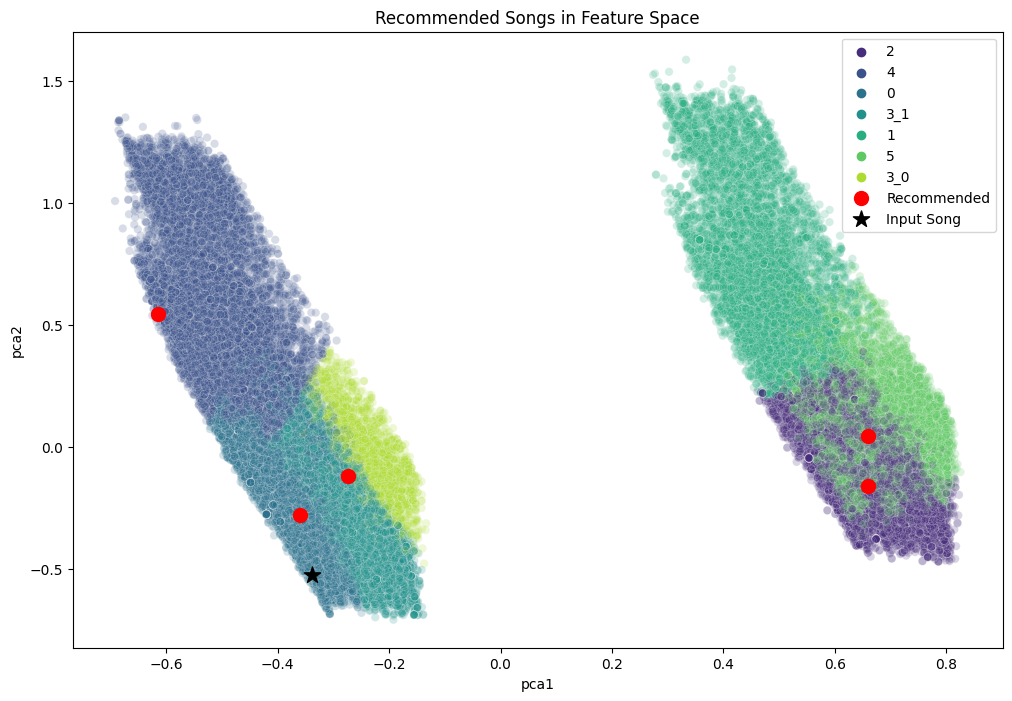

In [89]:
# Get recommended song indices
input_song = music_df[music_df['name'] == "Blinding Lights"].iloc[0]
recommended_indices = recs.index

plt.figure(figsize=(12, 8))
sns.scatterplot(x='pca1', y='pca2', hue='cluster', 
                data=music_df, palette='viridis', alpha=0.2)
plt.scatter(x=music_df.loc[recommended_indices, 'pca1'], 
            y=music_df.loc[recommended_indices, 'pca2'],
            color='red', s=100, label='Recommended')
plt.scatter(x=[input_song['pca1']], y=[input_song['pca2']],
            color='black', s=150, marker='*', label='Input Song')
plt.legend()
plt.title("Recommended Songs in Feature Space")
plt.show()
